# 분류와 회귀

__감사말__

프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 4장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전 이상에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

__구글 코랩 설정__

'런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
TensorFlow 버전을 확인하려면 아래 명령문을 실행한다.

TensorFlow가 GPU를 사용하는지 여부를 확인하려면 아래 명령문을 실행한다.
아래와 같은 결과가 나오면 GPU가 제대로 지원됨을 의미한다.

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**참고**

Keras의 백엔드를 지정한다. 'tensorflow', 'pytorch', 'jax' 중에 어떤 하나를 선택해도 상관이 없다. 다만 선택에 따라 모델 학습의 결과가 조금씩 달라질 뿐이다.

In [7]:
import os
os.environ["KERAS_BACKEND"] = "jax"

## 영화 후기: 이진 분류

**IMDB 데이터셋**

In [8]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000
)

훈련셋, 테스트셋의 크기 모두 25,000이다.

In [9]:
len(train_data)

25000

In [10]:
len(test_data)

25000

데이터 각각은 정수들의 리스트이다.

In [15]:
type(train_data[0])

list

첫째 후기의 처음 10개의 정수는 다음과 같다.

In [17]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

각 샘플(후기)들의 크기는 서로 다르다.

In [18]:
len(train_data[0])

218

In [19]:
len(train_data[1])

189

각 샘플의 레이블은 0(부정) 또는 1(긍정)이다.

In [20]:
train_labels[0]

np.int64(1)

In [21]:
test_labels[0]

np.int64(0)

**_영화 후기 내용_**

후기 분류를 위해 반드시 필요한 과정은 아니지만
원한다면 후기의 내용을 확인할 수 있다.
그러기 위해 정수와 단어 사이의 관계를 담은 사전 객체 가져온다.

In [22]:
word_index = imdb.get_word_index()

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


`word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [23]:
for item in list(word_index.items())[:10]:
    print(item)

('fawn', 34701)
('tsukino', 52006)
('nunnery', 52007)
('sonja', 16816)
('vani', 63951)
('woods', 1408)
('spiders', 16115)
('hanging', 2345)
('woody', 2289)
('trawling', 52008)


정수와 단어의 관계를 서로 바꾼다.

In [24]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

`reverse_word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [25]:
for item in list(reverse_word_index.items())[:10]:
    print(item)

(34701, 'fawn')
(52006, 'tsukino')
(52007, 'nunnery')
(16816, 'sonja')
(63951, 'vani')
(1408, 'woods')
(16115, 'spiders')
(2345, 'hanging')
(2289, 'woody')
(52008, 'trawling')


첫째 리뷰 내용을 아래와 같이 확인할 수 있다.
그런데 단어 인덱스에서 3을 빼야 한다.
이유는 0, 1, 2 인덱스는 각각 여백, 문장 시작, 불분명을 의미하기 때문이다.

In [26]:
first_review = train_data[0]

decoded_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in first_review])

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

**데이터 전처리: 벡터화, 멀티-핫-인코딩**

멀티-핫-인코딩을 이용한 벡터화를 진행하는 함수다.

In [27]:
import numpy as np

def multi_hot_encode(sequences, num_classes):
    results = np.zeros((len(sequences), num_classes))
    for i, sequence in enumerate(sequences):
        results[i][sequence] = 1.0
    return results

훈련셋과 테스트셋를 벡터화한다.

In [28]:
x_train = multi_hot_encode(train_data, num_classes=10000)
x_test = multi_hot_encode(test_data, num_classes=10000)

첫째 훈련 샘플의 변환 결과는 다음과 같다.
결과를 보면 원래의 첫째 훈련 샘플에 0은 포함되지 않았지만 1과 2는 사용되었음을 알 수 있다.

In [29]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

실제로 확인해보면 다음과 같다.

In [30]:
0 in train_data[0]

False

In [31]:
1 in train_data[0]

True

In [32]:
2 in train_data[0]

True

레이블 또한 정수 자료형에서 `float32` 자료형으로 변환해서 자료형을 일치시킨다.

In [33]:
y_train = train_labels.astype("float32")
y_test = test_labels.astype("float32")

In [34]:
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [35]:
y_test

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

**모델 구성**

In [36]:
import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

**모델 컴파일**

In [37]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

**검증셋 지정**

In [38]:
# 검증 세트
x_val = x_train[:10000]
y_val = y_train[:10000]

# 훈련셋
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

**모델 훈련**

In [39]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.6206 - loss: 0.6343 - val_accuracy: 0.8575 - val_loss: 0.4222
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8938 - loss: 0.3410 - val_accuracy: 0.8883 - val_loss: 0.2987
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9377 - loss: 0.2091 - val_accuracy: 0.8885 - val_loss: 0.2786
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9564 - loss: 0.1512 - val_accuracy: 0.8857 - val_loss: 0.2851
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9720 - loss: 0.1140 - val_accuracy: 0.8843 - val_loss: 0.2962
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9790 - loss: 0.0900 - val_accuracy: 0.8815 - val_loss: 0.3150
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9872 - loss: 0.0694 - val_accuracy: 0.8800 - val_loss: 0.3372
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9925 - loss: 0.0526 - val_accuracy: 0.8772 - 

**`History` 객체 활용**

`history` 속성: 평가지표를 사전 자료형으로 저장

In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

*손실값의 변화*

In [41]:
import matplotlib.pyplot as plt

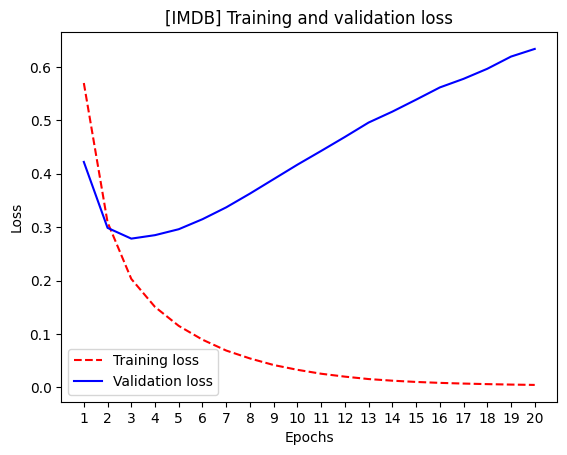

In [42]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r--", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("[IMDB] Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

*정확도의 변화*

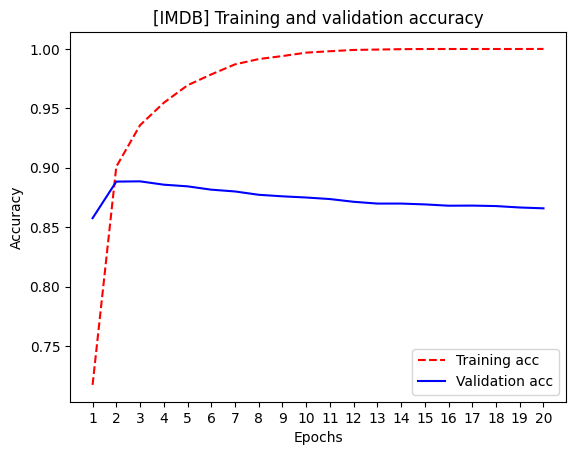

In [43]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("[IMDB] Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**모델 재훈련**

In [44]:
model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7279 - loss: 0.5877
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9132 - loss: 0.2518
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9424 - loss: 0.1698
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9546 - loss: 0.1372


테스트셋에 대한 성능은 아래와 같이 88% 정도의 정확도를 보인다.

In [45]:
results = model.evaluate(x_test, y_test)
results

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8768 - loss: 0.3237


[0.32074326276779175, 0.8790799975395203]

**모델 활용**

훈련된 모델을 활용하려면 `predict()` 메서드를 이용한다.

In [46]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[0.14616954],
       [0.9999883 ],
       [0.8545079 ],
       ...,
       [0.09360358],
       [0.05119571],
       [0.72507876]], dtype=float32)

데이터셋이 매우 클 경우 배치 사이즈를 아래처럼 변경할 수도 있다.
기본 배치 크기는 32다.

In [47]:
model.predict(x_test, batch_size=512)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


array([[0.1461696 ],
       [0.9999883 ],
       [0.8545079 ],
       ...,
       [0.09360354],
       [0.05119571],
       [0.7250786 ]], dtype=float32)

## 뉴스 기사: 다중 클래스 분류

**로이터 데이터셋**

In [48]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


훈련셋 크기

In [49]:
len(train_data)

8982

테스트셋 크기

In [50]:
len(test_data)

2246

주제에 따라 뉴스 기사의 개수가 다르다.
훈련셋의 타깃에 사용된 값들의 빈도수를 확인하면 다음과 같다.

In [51]:
from collections import Counter

target_counter = Counter(train_labels)
target_counter

Counter({np.int64(3): 3159,
         np.int64(4): 1949,
         np.int64(16): 444,
         np.int64(19): 549,
         np.int64(8): 139,
         np.int64(21): 100,
         np.int64(11): 390,
         np.int64(1): 432,
         np.int64(13): 172,
         np.int64(20): 269,
         np.int64(18): 66,
         np.int64(25): 92,
         np.int64(35): 10,
         np.int64(9): 101,
         np.int64(38): 19,
         np.int64(10): 124,
         np.int64(28): 48,
         np.int64(2): 74,
         np.int64(6): 48,
         np.int64(12): 49,
         np.int64(7): 16,
         np.int64(30): 45,
         np.int64(34): 50,
         np.int64(15): 20,
         np.int64(14): 26,
         np.int64(32): 32,
         np.int64(41): 30,
         np.int64(40): 36,
         np.int64(45): 18,
         np.int64(23): 41,
         np.int64(42): 13,
         np.int64(26): 24,
         np.int64(24): 62,
         np.int64(37): 19,
         np.int64(27): 15,
         np.int64(31): 39,
         np.int64(39):

가장 많이 언급된 주제는 총 3159번,
자장 적게 언급딘 주제는 총 10번 기사로 작성되었다.

In [52]:
print(f"최대 기사 수: {max(target_counter.values())}")
print(f"최소 기사 수: {min(target_counter.values())}")

최대 기사 수: 3159
최소 기사 수: 10


기사는 총 46개의 주제로 나뉜다.

In [53]:
len(target_counter)

46

각 샘플은 정수들의 리스트이다.

In [55]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

각 샘플 리스트의 길이가 일반적으로 다르다.

In [56]:
len(train_data[10])

31

In [57]:
len(train_data[11])

59

각 샘플에 대한 레이블은 0부터 45까지의 정수로 표현된다.
예를 들어, 10번 기사의 주제는 3이다.

In [58]:
train_labels[10]

np.int64(3)

실제로 10번 기사 내용을 확인해보면 'earn'과 관련되어 있어 보인다.
데이터를 해독(decoding)하는 방법은 IMDB 데이터셋의 경우와 동일하다.

In [59]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


10번 기사 내용은 다음과 같다.

In [60]:
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[10]])

decoded_newswire

'? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'

**데이터 전처리**

IMDB의 경우와 동일하게 길이가 10,000인 벡터로 모든 샘플을 변환한다.

In [61]:
x_train = multi_hot_encode(train_data, num_classes=10000)
x_test = multi_hot_encode(test_data, num_classes=10000)

훈련셋의 레이블과 테스트셋의 레이블은 원-핫 인코딩한다.


In [62]:
def one_hot_encode(labels, num_classes=46):
    results = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        results[i, label] = 1.0
    return results

y_train = one_hot_encode(train_labels)
y_test = one_hot_encode(test_labels)

케라스의 `to_categorical()` 함수가 원-핫-인코딩을 지원한다.

In [63]:
from keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

첫째 뉴스 기사의 주제는 3번이며 따라서 3번 인덱스만 1이고 나머지는 모두 0인, 길이가 46인 어레이가 타깃이 된다.

In [64]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

**모델 구성**

In [65]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

**모델 컴파일**

정확도 이외에 top_3_accuracy를 평가지표로 추가한다.

In [66]:
top_3_accuracy = keras.metrics.TopKCategoricalAccuracy(
    k=3, name="top_3_accuracy"
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", top_3_accuracy],
)

**참고 사항**

만약 라벨을 원-핫-인코딩 하지 않고 0부터 45 사이의 정수 형식으로 그대로 사용한다면 손실함수를 "sparse_categorical_crossentropy"로 지정해야 한다.

**모델 훈련**

처음 1,000개의 샘플을 검증 세트 용도로 사용한다.

In [ ]:
# 검증 세트
x_val = x_train[:1000]
y_val = y_train[:1000]

# 훈련셋
partial_x_train = x_train[1000:]
partial_y_train = y_train[1000:]

훈련 방식은 이전과 동일하다.

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.2694 - loss: 3.5405 - top_3_accuracy: 0.3785 - val_accuracy: 0.5080 - val_loss: 2.5201 - val_top_3_accuracy: 0.6700
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5661 - loss: 2.2066 - top_3_accuracy: 0.7044 - val_accuracy: 0.6550 - val_loss: 1.6928 - val_top_3_accuracy: 0.7500
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6967 - loss: 1.4890 - top_3_accuracy: 0.7753 - val_accuracy: 0.7030 - val_loss: 1.3366 - val_top_3_accuracy: 0.8000
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7529 - loss: 1.1243 - top_3_accuracy: 0.8435 - val_accuracy: 0.7400 - val_loss: 1.1691 - val_top_3_accuracy: 0.8410
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8078 - loss: 0.8894 - top_3_accuracy: 0.8933 - val_accuracy: 0.7610 - val_loss: 1.0520 - val_top_3_accuracy: 0.8770
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8538 - loss: 0.7019 - top_3_a

*손실값의 변화*

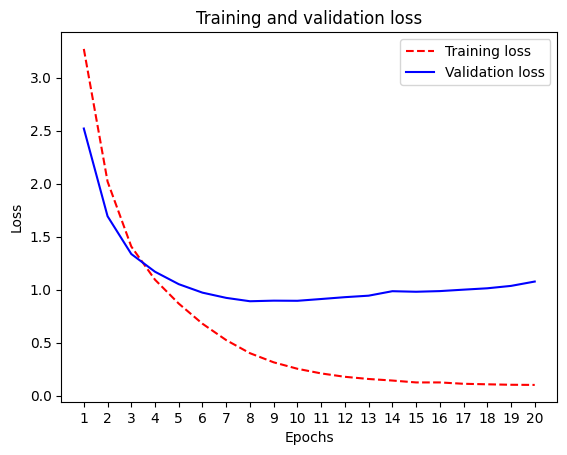

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

*정확도의 변화*

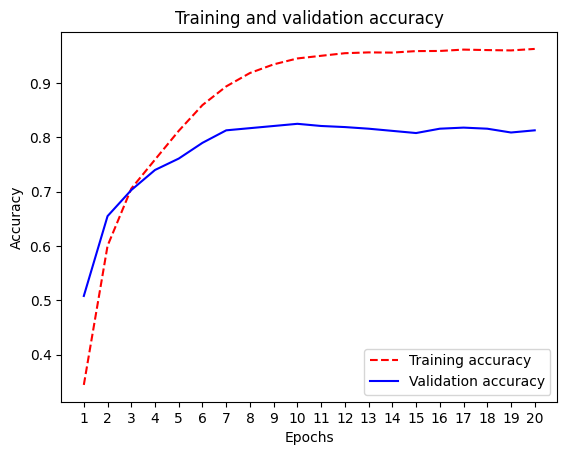

In [ ]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

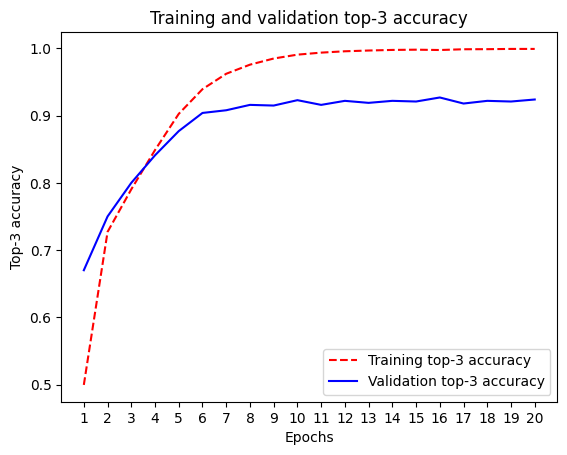

In [ ]:
plt.clf()
acc = history.history["top_3_accuracy"]
val_acc = history.history["val_top_3_accuracy"]
plt.plot(epochs, acc, "r--", label="Training top-3 accuracy")
plt.plot(epochs, val_acc, "b", label="Validation top-3 accuracy")
plt.title("Training and validation top-3 accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Top-3 accuracy")
plt.legend()
plt.show()

**모델 재훈련**

에포크를 9번만 실행.

In [ ]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)

Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3173 - loss: 3.1969
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6640 - loss: 1.6635
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7399 - loss: 1.2138
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7904 - loss: 0.9549
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8315 - loss: 0.7871
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8679 - loss: 0.6343
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8907 - loss: 0.5318
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9111 - loss: 0.4443
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9258 - loss: 0.3683


훈련된 모델을 이용한 테스트셋에 대한 예측의 정확도는 80% 정도이다.

In [ ]:
results = model.evaluate(x_test, y_test)

results

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8008 - loss: 0.8863


[0.9152839779853821, 0.7916295528411865]

80%의 정확도가 얼마나 좋은지/나쁜지를 판단하려면 무작위로 찍을 때의 정확도를 계산해봐야 한다.
아래 코드가 이를 실천하며, 20% 정도의 정확도가 나온다.
따라서 80% 정도의 정확도는 상당히 좋은 편이다.

In [ ]:
import copy

# 원 데이터를 건드리지 않기 위해 사본 사용
test_labels_copy = copy.copy(test_labels)

# 무작위로 섞은 후 원 데이터의 순서와 비교
np.random.shuffle(test_labels_copy)
hits_array = test_labels == test_labels_copy

# 1 또는 0으로만 이루어졌기에 평균값을 계산하면 무작위 선택의 정확도를 계산함
hits_array.mean()

np.float64(0.1794300979519145)

**모델 활용**

훈련된 모델을 테스트셋에 적용한다.

In [ ]:
predictions = model.predict(x_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


예측값의 모두 길이가 46인 1차원 어레이다.

In [ ]:
predictions[0].shape

(46,)

예측값은 46개 클래스에 들어갈 확률들로 이루어지며 합은 1이다.

In [ ]:
np.sum(predictions[0])

np.float32(0.9999999)

가장 큰 확률값을 가진 인덱스가 모델이 예측하는 클래스가 된다.
예를 들어 테스트셋의 0번 샘플(로이터 기사)은 3번 레이블을 갖는다고 예측된다.

In [ ]:
np.argmax(predictions[0])

np.int64(3)

**정보 병목**

은닉층에 사용되는 유닛은 마지막 층의 유닛보다 많아야 한다.
그렇지 않으면 정보전달 과정에 병목현상(bottleneck)이 발생할 수 있다.
아래 코드의 둘째 은닉층은 4 개의 유닛만을 사용하는데
훈련된 모델의 성능이 많이 저하된다.

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.1890 - loss: 3.2090 - val_accuracy: 0.5680 - val_loss: 2.2009
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5512 - loss: 2.0275 - val_accuracy: 0.6170 - val_loss: 1.6645
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6595 - loss: 1.5282 - val_accuracy: 0.6760 - val_loss: 1.4145
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7023 - loss: 1.2791 - val_accuracy: 0.7000 - val_loss: 1.3084
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7314 - loss: 1.1008 - val_accuracy: 0.7060 - val_loss: 1.2755
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7434 - loss: 1.0132 - val_accuracy: 0.7170 - val_loss: 1.2173
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7756 - loss: 0.8874 - val_accuracy: 0.7310 - val_loss: 1.2314
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7945 - loss: 0.8349 - val_accuracy: 0.7320 - val_loss

테스트셋에 대한 정확도가 80% 정도에서 65% 정도로 낮아진다.

In [ ]:
model.evaluate(x_test, y_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7151 - loss: 1.6707


[1.693705439567566, 0.7021371126174927]

## 주택가격 예측: 회귀

**보스턴 주택가격 데이터셋**

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)

훈련셋 샘플의 타깃은 아래처럼 범위가 지정되지 않은 부동소수점 값이다.

In [ ]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

**데이터 전처리**

특성에 따라 사용되는 값들의 크기가 다르다.
어떤 특성은 0과 1사이, 다른 특성은 한 자리부터 세 자리의 수를 갖기도 한다.

In [ ]:
import pandas as pd

pd.DataFrame(train_data).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


*데이터 표준화*

특성들의 스케일을 통일시키기 위해 특성별로 표준화를 진행한다.

In [ ]:
# 훈련셋의 특성별 평균값/표준편차
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

# 훈련셋 표준화
train_data -= mean
train_data /= std

테스트셋도 표준화한다. 다만 훈련셋의 평균값과 표준편차를 활용함에 주의한다.
이유는 테스트셋에 대한 어떤 정보도 미리 알 수 없다는 전제가 실현되야 하기 때문이다.

In [ ]:
# 테스트셋 표준화
test_data -= mean
test_data /= std

**모델 구성**

이번 훈련에서는 동일한 모델을 반복해서 지정하고 컴파일해야 할 예정이다.
따라서 함수 구성과 컴파일을 한 번에 실행하는 함수를 선언한다.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

**모델 훈련**

*예제: 3-겹 교차검증*

In [ ]:
from sklearn.model_selection import KFold

k = 3
num_epochs = 300

kf = KFold(n_splits=k)
all_mae_histories = []   # 모든 에포크에 대한 평균절대오차 저장

i = 0
for train_index, val_index in kf.split(train_data, train_targets):
    i+=1
    print(f"{i}번 째 폴드(fold) 훈련 시작")

    val_data, val_targets = train_data[val_index], train_targets[val_index]
    partial_train_data, partial_train_targets = train_data[train_index], train_targets[train_index]

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)

    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

1번 째 폴드(fold) 훈련 시작
2번 째 폴드(fold) 훈련 시작
3번 째 폴드(fold) 훈련 시작


에포크별 MAE 평균값 그래프 그리기

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

에포크별 평균절대오차의 평균값의 변화를 그래프로 그리면 다음과 같다.

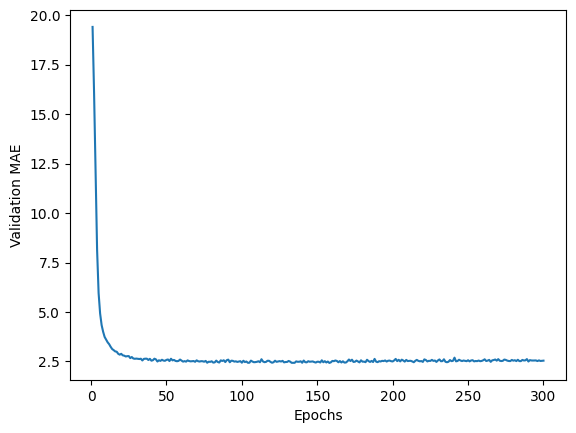

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

첫 10개의 에포크의 성능이 매우 나쁘기에 그 부분을 제외하고 그래프를 그리면 보다 정확하게
변환 과정을 파악할 수 있다.

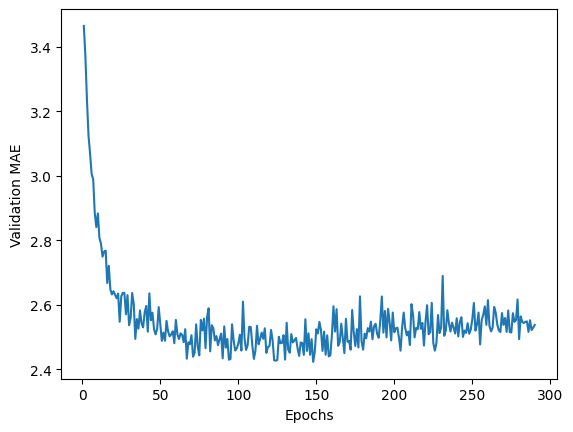

In [ ]:
truncated_mae_history = average_mae_history[10:]

plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**모델 재훈련**

과대적합이 발생하는 에포크를 아래와 같이 확인한다.

In [ ]:
# 최소의 mae가 위치한 인덱스 확인
overfitting_epoch = np.argmin(average_mae_history)
overfitting_epoch

157

과대적합이 발생하기 이전까지의 에포크만 이용해서
모델을 처음부터 재훈련한다.

In [ ]:
model = build_model()
model.fit(train_data,
          train_targets,
          epochs=overfitting_epoch,
          batch_size=16,
          verbose=0)

재훈련된 모델의 테스트셋에 대한 성능을 평가한다.

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 14.3688 - mae: 2.7425


2.888192892074585

**모델 활용**

In [ ]:
predictions = model.predict(test_data)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([10.15969], dtype=float32)

### 특성 `B` 제외 후 훈련 1편

`B` 특성을 제거하고 동일한 방식으로 모델을 훈련시킨 결과를 확인한다.

**데이터 불러오기**

데이터를 다시 불러온다.

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

**전처리: 특성 `B` 제거**

입력 데이터셋의 특성은 다음과 같다.

In [ ]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

In [ ]:
train_df = pd.DataFrame(train_data, columns=features)
train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [ ]:
test_df = pd.DataFrame(test_data, columns=features)
test_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,18.08460,0.0,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05
1,0.12329,0.0,10.01,0.0,0.547,5.913,92.9,2.3534,6.0,432.0,17.8,394.95,16.21
2,0.05497,0.0,5.19,0.0,0.515,5.985,45.4,4.8122,5.0,224.0,20.2,396.90,9.74
3,1.27346,0.0,19.58,1.0,0.605,6.250,92.6,1.7984,5.0,403.0,14.7,338.92,5.50
4,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44


In [ ]:
train_df = train_df.drop(['B'], axis=1)
test_df = test_df.drop(['B'], axis=1)

In [ ]:
train_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'],
      dtype='object')

In [ ]:
test_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'],
      dtype='object')

데이터프레임으로 계속 작업해도 되나
이전 코드를 그대로 사용하기 위해 다시 넘파이 어레이로 변환한다.

In [ ]:
train_data = train_df.to_numpy()
test_data = test_df.to_numpy()

**데이터 표준화**

In [ ]:
# 훈련셋의 특성별 평균값/표준편차
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

# 훈련셋 표준화
train_data -= mean
train_data /= std

In [ ]:
# 테스트셋 표준화
test_data -= mean
test_data /= std

**모델 구성**

이번 훈련에서는 동일한 모델을 반복해서 지정하고 컴파일해야 할 예정이다.
따라서 함수 구성과 컴파일을 한 번에 실행하는 함수를 선언한다.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

**모델 훈련**

*예제: 3-겹 교차검증*

In [ ]:
k = 3
num_epochs = 300

kf = KFold(n_splits=k)
all_mae_histories = []   # 모든 에포크에 대한 평균절대오차 저장

i = 0
for train_index, val_index in kf.split(train_data, train_targets):
    i+=1
    print(f"{i}번 째 폴드(fold) 훈련 시작")

    val_data, val_targets = train_data[val_index], train_targets[val_index]
    partial_train_data, partial_train_targets = train_data[train_index], train_targets[train_index]

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)

    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

1번 째 폴드(fold) 훈련 시작
2번 째 폴드(fold) 훈련 시작
3번 째 폴드(fold) 훈련 시작


에포크별 MAE 평균값 그래프 그리기

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

에포크별 평균절대오차의 평균값의 변화를 그래프로 그리면 다음과 같다.
첫 10개의 에포크의 성능이 매우 나쁘기에 그 부분을 제외하고 그래프를 그리면 보다 정확하게
변환 과정을 파악할 수 있다.

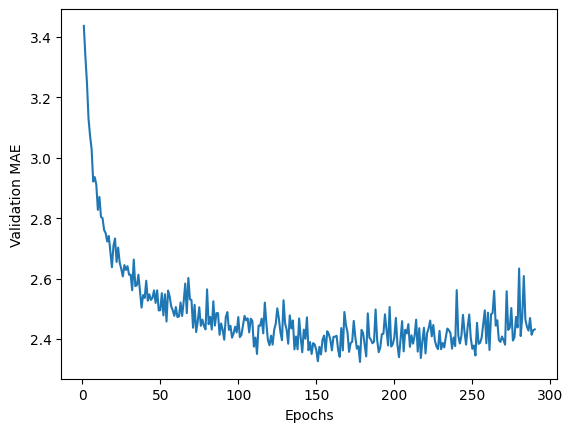

In [ ]:
truncated_mae_history = average_mae_history[10:]

plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**모델 재훈련**

In [ ]:
# 최소의 mae가 위치한 인덱스 확인
overfitting_epoch = np.argmin(average_mae_history)

model = build_model()
model.fit(train_data,
          train_targets,
          epochs=overfitting_epoch,
          batch_size=16,
          verbose=0)

과대적합이 발생하기 이전까지의 에포크만 사용하여 재훈련된 모델의 테스트셋에 대한 성능을 평가하면
특성 `B`를 추가했을 때와 성능이 비슷하게 나온다.

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 12.7020 - mae: 2.5867


2.726799964904785

### 특성 `B` 제외 후 훈련 2편

`B` 특성을 제거한 다음에 데이터 전처리를 좀 더 수행한다.

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

**전처리: 특성 `B` 제거**

In [ ]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

In [ ]:
train_df = pd.DataFrame(train_data, columns=features)
test_df = pd.DataFrame(test_data, columns=features)

In [ ]:
train_df = train_df.drop(['B'], axis=1)
test_df = test_df.drop(['B'], axis=1)

**전처리: 범주형 특성 원-핫 인코딩**

특성 `'CHAS'`는 찰스강<font size='2'>Charles River</font>과의 인접성 여부를 판단하는
범주형 데이터다.
따라서 이들을 모두 원-핫 인코딩할 필요가 있다.

In [ ]:
train_df['CHAS'].unique()

array([0., 1.])

데이터프레임의 일부 특성을 원-핫 인코딩하기 위해 `pd.get_dummies()` 함수를 이용한다.
참고로 더미<font size='2'>dummy</font>는 부가적으로 추가된 요소를 의미한다.

- `data`: 변환 대상 데이터프레임 지정
- `columns`: 원-핫 인코딩 대상 특성들의 리스트 지정
- `prefix`: 새롭게 생성되는 더미 특성들의 이름에 사용될 접두사 지정
- `dtype`: 새롭게 생성되는 값들의 자료형 지정

원-핫 인코딩 대상으로 지정된 특성들은 삭제되고 대신 새로운 더미 특성들이 추가된다.

In [ ]:
train_df_dummy = pd.get_dummies(data= train_df,
                               columns=['CHAS'],
                               prefix=['CHAS'],
                               dtype='float64')

In [ ]:
train_df_dummy.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,CHAS_0.0,CHAS_1.0
0,1.23247,0.0,8.14,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,18.72,1.0,0.0
1,0.02177,82.5,2.03,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,3.11,1.0,0.0
2,4.89822,0.0,18.10,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,3.26,1.0,0.0
3,0.03961,0.0,5.19,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,8.01,1.0,0.0
4,3.69311,0.0,18.10,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,14.65,1.0,0.0


테스트셋에 대해서도 동일하게 진행한다.

In [ ]:
test_df_dummy = pd.get_dummies(data= test_df,
                               columns=['CHAS'],
                               prefix=['CHAS'],
                               dtype='float64')

**데이터 표준화**

`Chas` 더미 특성을 제외한 다른 특성들은 모두 표준화한다.

In [ ]:
train_df_wCHAS = train_df_dummy.drop(['CHAS_0.0', 'CHAS_1.0'], axis=1)

In [ ]:
# 훈련셋의 특성별 평균값/표준편차
mean = train_df_wCHAS.mean(axis=0)
std = train_df_wCHAS.std(axis=0)

# 훈련셋 표준화
train_df_wCHAS -= mean
train_df_wCHAS /= std

테스트셋 표준화

In [ ]:
test_df_wCHAS = test_df_dummy.drop(['CHAS_0.0', 'CHAS_1.0'], axis=1)

In [ ]:
test_df_wCHAS -= mean
test_df_wCHAS /= std

`Chas` 더미 특성을 다시 추가한다.

In [ ]:
train_df_standardized = pd.concat([train_df_wCHAS, train_df_dummy[['CHAS_0.0', 'CHAS_1.0']]], axis=1)

In [ ]:
train_df_standardized.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,CHAS_0.0,CHAS_1.0
0,-0.271909,-0.483017,-0.435222,-0.165022,-0.176224,0.812055,0.116554,-0.625474,-0.594433,1.147078,0.824198,1.0,0.0
1,-0.402927,2.988079,-1.332260,-1.213677,1.892000,-1.907995,1.246040,-0.855402,-0.348001,-1.716061,-1.327556,1.0,0.0
2,0.124785,-0.483017,1.027052,0.627864,-1.827422,1.109113,-1.185969,1.673810,1.563349,0.783505,-1.306880,1.0,0.0
3,-0.400996,-0.483017,-0.868325,-0.361112,-0.324156,-1.235140,1.105809,-0.510509,-1.093307,0.783505,-0.652118,1.0,0.0
4,-0.005627,-0.483017,1.027052,1.326967,0.153452,0.693948,-0.577856,1.673810,1.563349,0.783505,0.263171,1.0,0.0


In [ ]:
test_df_standardized = pd.concat([test_df_wCHAS, test_df_dummy[['CHAS_0.0', 'CHAS_1.0']]], axis=1)

In [ ]:
test_df_standardized.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,CHAS_0.0,CHAS_1.0
0,1.551769,-0.483017,1.027052,1.037095,0.235167,1.109113,-0.938606,1.673810,1.563349,0.783505,2.248133,1.0,0.0
1,-0.391941,-0.483017,-0.160679,-0.088291,-0.498856,0.855003,-0.683115,-0.395545,0.156884,-0.307215,0.478208,1.0,0.0
2,-0.399334,-0.483017,-0.868325,-0.361112,-0.397417,-0.845028,0.527988,-0.510509,-1.093307,0.783505,-0.413646,1.0,0.0
3,-0.267473,-0.483017,1.244338,0.406197,-0.024066,0.844266,-0.956485,-0.510509,-0.017422,-1.716061,-0.998108,0.0,1.0
4,-0.397544,-0.483017,-0.971096,-0.923805,-0.205810,-0.437021,0.003610,-0.740438,-0.955065,0.010912,-0.592844,1.0,0.0


데이터프레임으로 계속 작업해도 되나
이전 코드를 그대로 사용하기 위해 다시 넘파이 어레이로 변환한다.

In [ ]:
train_data = train_df_standardized.to_numpy()
test_data = test_df_standardized.to_numpy()

**모델 훈련**

*예제: 4-겹 교차검증*

In [ ]:
k = 4
num_epochs = 400

kf = KFold(n_splits=k)
all_mae_histories = []   # 모든 에포크에 대한 평균절대오차 저장

i = 0
for train_index, val_index in kf.split(train_data, train_targets):
    i+=1
    print(f"{i}번 째 폴드(fold) 훈련 시작")

    val_data, val_targets = train_data[val_index], train_targets[val_index]
    partial_train_data, partial_train_targets = train_data[train_index], train_targets[train_index]

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)

    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

1번 째 폴드(fold) 훈련 시작
2번 째 폴드(fold) 훈련 시작
3번 째 폴드(fold) 훈련 시작
4번 째 폴드(fold) 훈련 시작


에포크별 MAE 평균값 그래프 그리기

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

에포크별 평균절대오차의 평균값의 변화를 그래프로 그리면 다음과 같다.
첫 10개의 에포크의 성능이 매우 나쁘기에 그 부분을 제외하고 그래프를 그리면 보다 정확하게
변환 과정을 파악할 수 있다.
무엇보다도 과대적합이 보다 늦게 발생함을 확인할 수 있다.

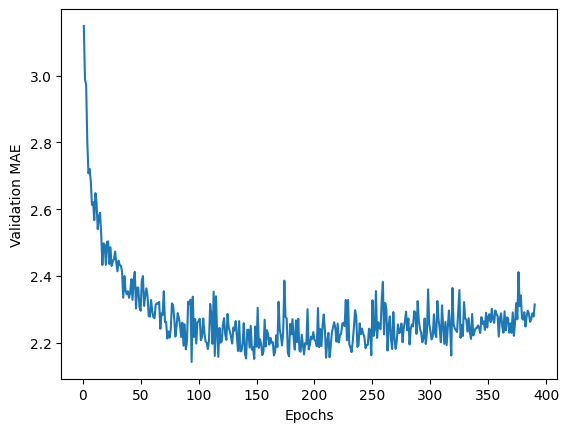

In [ ]:
truncated_mae_history = average_mae_history[10:]

plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**모델 재훈련**

In [ ]:
# 최소의 mae가 위치한 인덱스 확인
overfitting_epoch = np.argmin(average_mae_history)

model = build_model()
model.fit(train_data,
          train_targets,
          epochs=overfitting_epoch,
          batch_size=16,
          verbose=0)

과대적합이 발생하기 이전까지의 에포크를 이용하여 재훈련된 모델의 테스트셋에 대한 성능을 평가하면
특성 `B`를 추가한 최초의 모델보다 성능이 많이 좋아진다.

앞서 확인한대로 이는 과대적합이 보다 늦게 발생하기 때문이다.
즉, 과대적합 없이 오랫동안 훈련한 모델일 수록 성능이 좋아진다.

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 11.8448 - mae: 2.4151


2.527559518814087

**결론**

특정 특성의 유효성 여부를 확인하는 일반적인 방식을 적용해 보았다.
결과적으로 특성 `B`를 포함하지 않더라도 성능이 좋은 모델을 훈련시킬 수 있음을 확인하였다.
이는 특성 `B`의 유효성이 그리 높지 않음을 알 수 있다.